In [1]:
import os
os.chdir('/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.load_data import load_data
from utils.plot_history import plot_history

2024-05-14 14:27:04.779252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 14:27:04.893386: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 14:27:05.492583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 14:27:07.754885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
DATA_PATH = "./data/data_25ms_16mfcc.json"
SAVED_MODEL_PATH = "./models/cnn2d/model.keras"
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [4]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.

    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation

    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)

    from sklearn.preprocessing import MinMaxScaler

    # initialisez le scaler
    scaler = MinMaxScaler()

    # redimensionnez X en 2D pour le scaling
    X_2d = X.reshape(-1, X.shape[-1])

    # ajustez et transformez les données
    X_scaled = scaler.fit_transform(X_2d)

    # redimensionnez X à sa forme originale
    X_normalized = X_scaled.reshape(X.shape)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [5]:
# def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
#     """Build neural network using keras.

#     :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
#     :param loss (str): Loss function to use
#     :param learning_rate (float):

#     :return model: TensorFlow model
#     """

#     # build network architecture using convolutional layers
#     model = tf.keras.models.Sequential()

#     # 1st conv layer
#     model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', input_shape=input_shape,
#                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(1,1), padding='same'))

#     # 2nd conv layer
#     model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
#                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(1,1), padding='same'))


#     # 3rd conv layer
#     model.add(tf.keras.layers.Conv2D(32, (1, 1), activation='relu',
#                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1,1), padding='same'))


#     # flatten output and feed into dense layer
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(64, activation='relu'))
#     tf.keras.layers.Dropout(0.3)

#     # softmax output layer
#     model.add(tf.keras.layers.Dense(2, activation='softmax'))

#     optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

#     # compile model
#     model.compile(optimizer=optimiser,
#                   loss=loss,
#                   metrics=["accuracy"])

#     # print model parameters on console
#     model.summary()

#     return model

In [6]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.

    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):

    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))


    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # softmax output layer
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


In [7]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model

    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set

    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

Training sets loaded!
(179244, 3, 16, 1)


/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 3, 16, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,867 (331.51 KB)

 Trainable params: 84,867 (331.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.5147 - loss: 0.9595 - val_accuracy: 0.6386 - val_loss: 0.7837
Epoch 2/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.6346 - loss: 0.7844 - val_accuracy: 0.6609 - val_loss: 0.7295
Epoch 3/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.6615 - loss: 0.7343 - val_accuracy: 0.6820 - val_loss: 0.6907
Epoch 4/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.6812 - loss: 0.6980 - val_accuracy: 0.7010 - val_loss: 0.6634
Epoch 5/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.6944 - loss: 0.6740 - val_accuracy: 0.7117 - val_loss: 0.6421
Epoch 6/6
5602/5602 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.7059 - loss: 0.6554 - val_accuracy: 0.7208 - val_loss: 0.6244


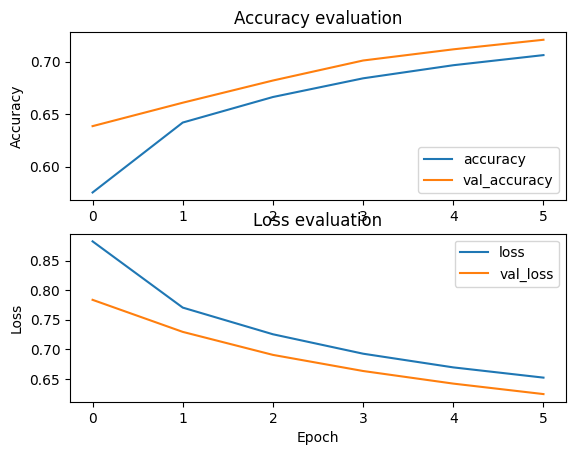

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7256 - loss: 0.6199

Test loss: 0.6201691627502441, test accuracy: 72.30156660079956


In [8]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

print(X_train.shape)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

# save model
model.save(SAVED_MODEL_PATH)

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Recall: 0.7169112399604103, F1 Score: 0.7162688839005713


Text(95.72222222222221, 0.5, 'Vrai')

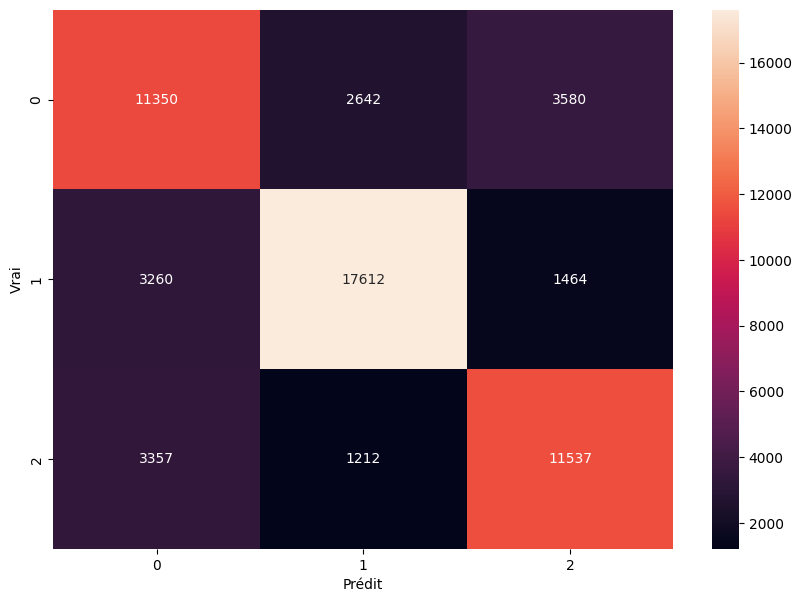

In [9]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
cm = confusion_matrix(y_test, y_pred_classes)

print("\nRecall: {}, F1 Score: {}".format(recall, f1))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prédit')
plt.ylabel('Vrai')

In [12]:
y_pred = model.predict(X_test)

group_means = {}
for i in range(y_pred.shape[1]):
    group_means[i] = np.mean(X_test[y_pred[:, i] == 1], axis=0)

global_mean = np.mean(X_test, axis=0)

between_group_variance = np.sum([(len(X_test[y_pred[:, i] == 1]) * (group_mean - global_mean)**2) for i, group_mean in group_means.items()]) / (len(group_means) - 1)

within_group_variance = np.sum([(X_test[y_pred[:, i] == 1] - group_mean)**2 for i, group_mean in group_means.items()]) / (X_test.shape[0] - len(group_means))

F_ratio = between_group_variance / within_group_variance

# print f_ratio
print(F_ratio)

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
nan
